In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import math
from util import *
from vectoradam import *
from skimage import measure
from skimage.draw import disk
import imageio
import scipy
from nanomesh import Image as nmImg
from nanomesh import Mesher2D
import trimesh
import cv2
from svgpathtools import svg2paths
import mediapipe as mp
from einops import rearrange
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import Polygon, Point

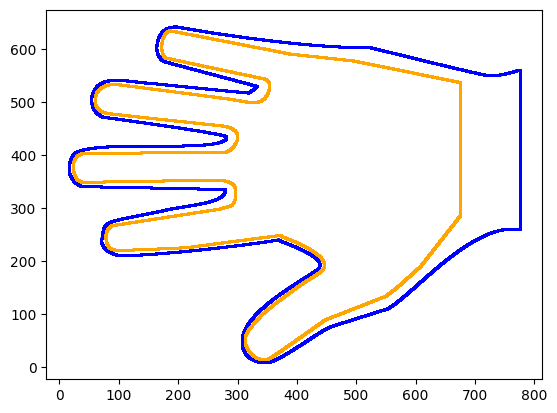

In [2]:
def samplePaths(file, NUM_SAMPLES=100000):
    # Load paths from SVG file
    paths, attributes = svg2paths(file)
    points = []
    line_segments = []
    for path in paths:
        for i in range(NUM_SAMPLES):
            points.append([path.point(i/(NUM_SAMPLES-1)).imag, path.point(i/(NUM_SAMPLES-1)).real])
            if i < NUM_SAMPLES: line_segments.append((i, i+1))

    return np.array(points), line_segments
        
outerCut, _ = samplePaths('assets/outerOnly.svg')
topTraces, _ = samplePaths('assets/top_trace.svg')
botttomTraces, _ = samplePaths('assets/bottom_trace.svg')
edgeCuts, _ = samplePaths('assets/edgeCuts.svg')
coverlayMask, _ = samplePaths('assets/solderMask.svg')



# Print the flipped vertices
plt.scatter(*zip(*outerCut), color='blue',s=1)
# plt.scatter(*zip(*topTraces), color='red',s=1)
# plt.scatter(*zip(*botttomTraces), color='green',s=1)
# plt.scatter(*zip(*edgeCuts), color='purple',s=1)
plt.scatter(*zip(*coverlayMask), color='orange',s=1)

I0000 00:00:1732918137.449822 2935939 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
/tmp/ipykernel_2935939/741208240.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('assets/right-hand-real.jpg')
I0000 00:00:1732918137.479383 2936288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: Quadro RTX 8000/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732918137.516332 2936273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732918137.530505 2936287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

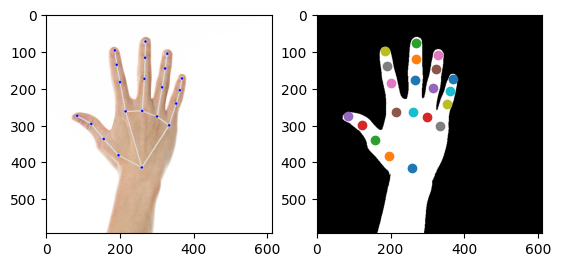

In [3]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

image = imageio.imread('assets/right-hand-real.jpg')

# Process the frame
result = hands.process(image)

binary_image = image.sum(-1) / (255*3)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask = binary_image < (binary_image.max()*0.9)

mask_rgb = rearrange(np.array(np.vstack([mask, mask, mask])*255, dtype=np.uint8), '(c h) w -> h w c', c=3) 
cv2.imwrite('mask.png', mask_rgb)
mask = cv2.imread("mask.png")  # Replace with your image
h, w = mask.shape[0], mask.shape[1]

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax2.imshow(mask)

# Draw landmarks and extract fingertip positions
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        hand_vertices = []
    for hand_landmarks in [result.multi_hand_landmarks[0]]:
        for idx in range(len(hand_landmarks.landmark)):
            x = (hand_landmarks.landmark[idx].x)
            y = (hand_landmarks.landmark[idx].y)
            ax2.scatter(x*w, y*h, label=f'{idx}')
            hand_vertices.append((x, y))
        mp_draw.draw_landmarks(mask, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    hand_vertices = np.array(hand_vertices)
ax1.imshow(image)

plt.show()

hand_landmarks = result.multi_hand_landmarks[0]


In [9]:

def get_finger_rectangle_patch(landmarks, mask, finger_indices):
    """
    Given the landmarks of a hand and a binary mask, this function finds rectangular patches
    for the given finger joints.
    
    :param landmarks: List of hand landmarks from MediaPipe (21 landmarks).
    :param mask: Binary mask of the hand (numpy array).
    :param finger_indices: List of tuples of indices for the finger joints, e.g., for the index finger, 
                            [(2, 3), (3, 4)] where 2 is the base joint and 4 is the fingertip.
    :return: List of rectangles (x, y, w, h) for each finger joint pair.
    """
    finger_rectangles = []
    
    # Loop through each set of finger joint pairs
    for start_idx, end_idx in finger_indices:
        # Get the 2D coordinates of the joints
        start_joint = landmarks[start_idx]
        end_joint = landmarks[end_idx]
        
        # Extract the x, y positions
        start_x, start_y = int(start_joint.x * mask.shape[1]), int(start_joint.y * mask.shape[0])
        end_x, end_y = int(end_joint.x * mask.shape[1]), int(end_joint.y * mask.shape[0])
        
        # Calculate the height and width of the rectangle
        width = int(np.linalg.norm([start_x - end_x, start_y - end_y]))  # Distance between joints
        height = int(np.linalg.norm([start_x - end_x, start_y - end_y]))  # Same as width in this case
        
        # Find the bounding box (x, y, w, h) between the two points
        x1 = min(start_x, end_x)
        y1 = min(start_y, end_y)
        x2 = max(start_x, end_x)
        y2 = max(start_y, end_y)
        
        # Define the rectangle as (x, y, width, height)
        finger_rectangles.append((x1, y1, x2 - x1, y2 - y1))

    return finger_rectangles


def compute_perpendicular_vector(vector):
    """
    Compute a perpendicular vector in 2D.
    :param vector: Input vector (x, y).
    :return: Perpendicular vector (rotated 90 degrees counterclockwise).
    """
    return np.array([-vector[1], vector[0]])

def get_finger_polygons(landmarks, mask, finger_indices, width=10):
    """
    Compute polygons along the finger direction for each segment of the finger.
    
    :param landmarks: List of hand landmarks from MediaPipe (21 landmarks).
    :param mask: Binary mask of the hand (numpy array).
    :param finger_indices: List of tuples of indices for the finger joints.
    :param width: Half-width of the finger polygons.
    :return: List of polygons (each defined by four points).
    """
    finger_polygons = []
    
    for start_idx, end_idx in finger_indices:
        # Get the 2D coordinates of the start and end joints
        start_joint = landmarks[start_idx]
        end_joint = landmarks[end_idx]
        
        # Convert normalized landmarks to pixel coordinates
        start_x, start_y = int(start_joint.x * mask.shape[1]), int(start_joint.y * mask.shape[0])
        end_x, end_y = int(end_joint.x * mask.shape[1]), int(end_joint.y * mask.shape[0])
        
        # Compute the direction vector
        direction_vector = np.array([end_x - start_x, end_y - start_y])
        direction_vector = direction_vector / np.linalg.norm(direction_vector)  # Normalize
        
        # Compute the perpendicular vector for width
        perp_vector = compute_perpendicular_vector(direction_vector) * width
        
        # Define the four points of the polygon
        point1 = np.array([start_x, start_y]) + perp_vector
        point2 = np.array([start_x, start_y]) - perp_vector
        point3 = np.array([end_x, end_y]) - perp_vector
        point4 = np.array([end_x, end_y]) + perp_vector
        
        # Create a polygon (list of four points)
        finger_polygons.append(np.array([point1, point2, point3, point4]))
    
    return finger_polygons




def sample_and_connect_polygon_sides(polygon, num_points=3):
    """
    Sample equal spaced points on the two vertical sides of a polygon and connect them with lines.
    
    :param polygon: A polygon defined by four points (point1, point2, point3, point4).
    :param num_points: Number of equal spaced points to sample on each side.
    :return: A list of lines connecting the sampled points.
    """
    # Extract the points defining the polygon
    point1, point2, point3, point4 = polygon
    
    # Interpolate points on side1 (point1 -> point4) and side2 (point2 -> point3)
    side1_points = np.linspace(point1, point4, num_points)
    side2_points = np.linspace(point2, point3, num_points)
    
    # Connect corresponding points
    connecting_lines = [(side1_points[i], side2_points[i]) for i in range(num_points)]
    
    return connecting_lines



def sample_and_connect_polygon_other_sides(polygon, num_points=5):
    """
    Sample equal spaced points on the two vertical sides of a polygon and connect them with lines.
    
    :param polygon: A polygon defined by four points (point1, point2, point3, point4).
    :param num_points: Number of equal spaced points to sample on each side.
    :return: A list of lines connecting the sampled points.
    """
    # Extract the points defining the polygon
    point1, point2, point3, point4 = polygon
    
    # Interpolate points on side1 (point1 -> point4) and side2 (point2 -> point3)
    side1_points = np.linspace(point1, point2, num_points)
    side2_points = np.linspace(point4, point3, num_points)
    
    # Connect corresponding points
    connecting_lines = [(side1_points[i], side2_points[i]) for i in range(num_points)]
    
    return connecting_lines

def draw_polygon_with_lines(ax, image, polygon, num_points=5):
    """
    Draw a polygon and its sampled connecting lines on an image using Matplotlib.
    
    :param image: Background image (e.g., binary mask).
    :param polygon: A polygon defined by four points (point1, point2, point3, point4).
    :param num_points: Number of equal spaced points to sample on each side.
    """
    ax.imshow(image, cmap='gray')
    
    # Draw the polygon
    
    # Sample points and draw connecting lines
    connecting_lines = sample_and_connect_polygon_sides(polygon, num_points)
    for point1, point2 in connecting_lines:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='blue', linewidth=1)


    connecting_other_lines = sample_and_connect_polygon_other_sides(polygon, num_points)
    for point1, point2 in connecting_other_lines:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='cyan', linewidth=1)
    
    
def draw_finger_polygons_with_matplotlib(ax, image, finger_polygons):
    """
    Draws the polygons on the given image using Matplotlib.
    
    :param image: Input image (numpy array).
    :param finger_polygons: List of polygons (each defined by four points).
    """
    ax.imshow(image, cmap='gray')
    
    # Draw each polygon
    for polygon_points in finger_polygons:
        polygon = Polygon(polygon_points, closed=True, edgecolor='r', fill=False, linewidth=2)
        ax.add_patch(polygon)
        draw_polygon_with_lines(ax, image, polygon_points)



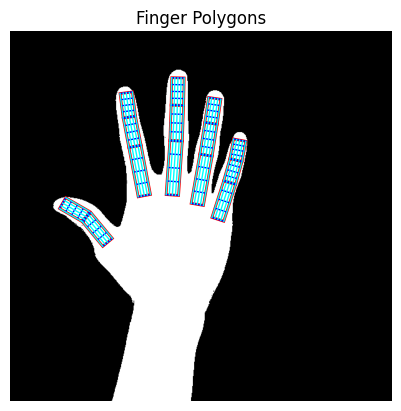

In [10]:
from matplotlib.patches import Rectangle, Polygon
fig, ax = plt.subplots()

finger_joint_pairs = [[2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], [17, 18], [18, 19], [19, 20]]
finger_rectangles = get_finger_polygons(hand_landmarks.landmark, mask, finger_joint_pairs)
electrode_traces = []
electrode_traces_other = []


for p in finger_rectangles:
    electrode_traces.append(sample_and_connect_polygon_sides(p))
    electrode_traces_other.append(sample_and_connect_polygon_other_sides(p))


draw_finger_polygons_with_matplotlib(ax, binary_image, finger_rectangles) 
    
plt.title("Finger Polygons")
plt.axis('off')
plt.show()


In [11]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def biharmonic_weights(vertices, segments):
    """
    Compute biharmonic weights based on the mesh connectivity.
    """
    num_vertices = len(vertices)
    
    L = sp.lil_matrix((num_vertices, num_vertices))
    for seg in segments:
        i, j = seg
        L[i, i] += 1
        L[j, j] += 1
        L[i, j] -= 1
        L[j, i] -= 1

    A = L.T @ L
    return A

def deform_shape(source_vertices, target_vertices, segments, alpha=0.1):
    """
    Deform the source shape to match the target shape using biharmonic weights.
    
    Parameters:
    - source_vertices: Nx2 array of (x, y) coordinates of the source shape.
    - target_vertices: Nx2 array of (x, y) coordinates of the target shape.
    - segments: List of pairs of indices defining the edges between vertices.
    - alpha: Regularization parameter for the biharmonic weights.
    
    Returns:
    - deformed_vertices: Nx2 array of the deformed vertices.
    """
    num_vertices = source_vertices.shape[0]

    A = biharmonic_weights(source_vertices, segments)

    I = sp.identity(num_vertices)
    system_matrix = A + alpha * I  # Regularized biharmonic system

    bx = alpha * target_vertices[:, 0]
    by = alpha * target_vertices[:, 1]
    
    deformed_x = spla.spsolve(system_matrix, bx)
    deformed_y = spla.spsolve(system_matrix, by)
    
    deformed_vertices = np.vstack((deformed_x, deformed_y)).T
    return deformed_vertices



In [12]:
def extrude_contour(vertices, extrusion_distance):
    """
    Extrudes the contour outward by a given distance based on local normals.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    vertices = np.asarray(vertices)
    num_vertices = len(vertices)

    extruded_vertices = []
    for i in range(num_vertices):
        prev_vertex = vertices[i - 1]
        curr_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % num_vertices]  # Wrap around

        tangent1 = curr_vertex - prev_vertex
        tangent2 = next_vertex - curr_vertex

        tangent1 /= np.linalg.norm(tangent1)
        tangent2 /= np.linalg.norm(tangent2)

        average_tangent = tangent1 + tangent2
        average_tangent /= np.linalg.norm(average_tangent)

        normal = np.array([-average_tangent[1], average_tangent[0]])

        extruded_vertex = curr_vertex + extrusion_distance * normal
        extruded_vertices.append(extruded_vertex)

    return np.array(extruded_vertices)


def intrude_contour(vertices, extrusion_distance):
    """
    Extrudes the contour outward by a given distance based on local normals.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    vertices = np.asarray(vertices)
    num_vertices = len(vertices)

    extruded_vertices = []
    for i in range(num_vertices):
        prev_vertex = vertices[i - 1]
        curr_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % num_vertices]  # Wrap around

        tangent1 = curr_vertex - prev_vertex
        tangent2 = next_vertex - curr_vertex

        tangent1 /= np.linalg.norm(tangent1)
        tangent2 /= np.linalg.norm(tangent2)

        average_tangent = tangent1 + tangent2
        average_tangent /= np.linalg.norm(average_tangent)

        normal = np.array([-average_tangent[1], average_tangent[0]])

        extruded_vertex = curr_vertex - extrusion_distance * normal
        extruded_vertices.append(extruded_vertex)

    return np.array(extruded_vertices)


def extrude_concave_shape(vertices, extrusion_distance):
    """
    Extrudes a concave shape by a specified distance.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    # Convert the vertices into a Shapely Polygon
    polygon = Polygon(vertices)

    # Perform the buffer operation for extrusion
    extruded_polygon = polygon.buffer(extrusion_distance)

    # Get the exterior coordinates of the extruded shape
    extruded_vertices = np.array(extruded_polygon.exterior.coords)

    return extruded_vertices


def extrude_outward(mask, extrusion_distance):
    """
    Extrude a binary mask outward by a specified distance.
    :param mask: 2D numpy array (binary mask where 1s represent the hand).
    :param extrusion_distance: Distance to extrude outward (in pixels).
    :return: 2D numpy array of the outward-extruded mask.
    """
    kernel_size = int(extrusion_distance * 2 + 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    extruded_mask = cv2.dilate(mask, kernel)
    return extruded_mask

def extrude_inward(mask, extrusion_distance):
    """
    Extrude a binary mask inward by a specified distance.
    :param mask: 2D numpy array (binary mask where 1s represent the hand).
    :param extrusion_distance: Distance to extrude inward (in pixels).
    :return: 2D numpy array of the inward-extruded mask.
    """
    kernel_size = int(extrusion_distance * 2 + 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    extruded_mask = cv2.erode(mask, kernel)
    return extruded_mask



def smooth_hand_mask(binary_mask, blur_kernel_size=5, morph_kernel_size=3):
    """
    Smooths out the hand binary mask by applying Gaussian blur and morphological operations.
    :param binary_mask: 2D binary mask (1s for hand, 0s for background).
    :param blur_kernel_size: Size of the kernel for Gaussian blur.
    :param morph_kernel_size: Size of the kernel for morphological operations.
    :return: Smoothed binary mask.
    """
    # Apply Gaussian blur to smooth out local details
    smoothed_mask = cv2.GaussianBlur(binary_mask, (blur_kernel_size, blur_kernel_size), 0)
    
    # Threshold the image to convert it back to binary after blurring
    _, smoothed_mask = cv2.threshold(smoothed_mask, 127, 255, cv2.THRESH_BINARY)

    # Create a kernel for morphological operations (a square or elliptical kernel works well)
    kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)

    # Apply morphological opening (erosion followed by dilation) to remove small noise
    smoothed_mask = cv2.morphologyEx(smoothed_mask, cv2.MORPH_OPEN, kernel)

    # Optionally, apply closing (dilation followed by erosion) to fill small gaps
    smoothed_mask = cv2.morphologyEx(smoothed_mask, cv2.MORPH_CLOSE, kernel)

    return smoothed_mask


def contour_hand(binary_image, boundary=-1, num_points=100000):

    binary_image = binary_image[:boundary, :]
    binary_image = binary_image.sum(-1) / binary_image.sum(-1).max()

    # Find contours in the binary image
    contours = measure.find_contours(binary_image, level=0.5)
    
    points = []
    line_segments = []
    
    contours = [contours[0]]

    for contour in contours:
        distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
        cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
        desired_distances = np.linspace(0, cumulative_distances[-1], num_points)
        interpolated_points = np.array([
            np.interp(desired_distances, cumulative_distances, contour[:, dim])
            for dim in range(contour.shape[1])
        ]).T
        
        points.extend(interpolated_points)
        
        for i in range(len(points) - 1):
            line_segments.append((i, i + 1))
        
        line_segments.append((i+1, 0))
    
    
    return np.array(points), line_segments



/tmp/ipykernel_2935939/3061146017.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread('mask.png')


original 58609710
255


/tmp/ipykernel_2935939/3061146017.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(inner_target_l[:, 1], inner_target_l[:, 0], s=0.05, c=colors[i], label=f'trace_{i+1}')


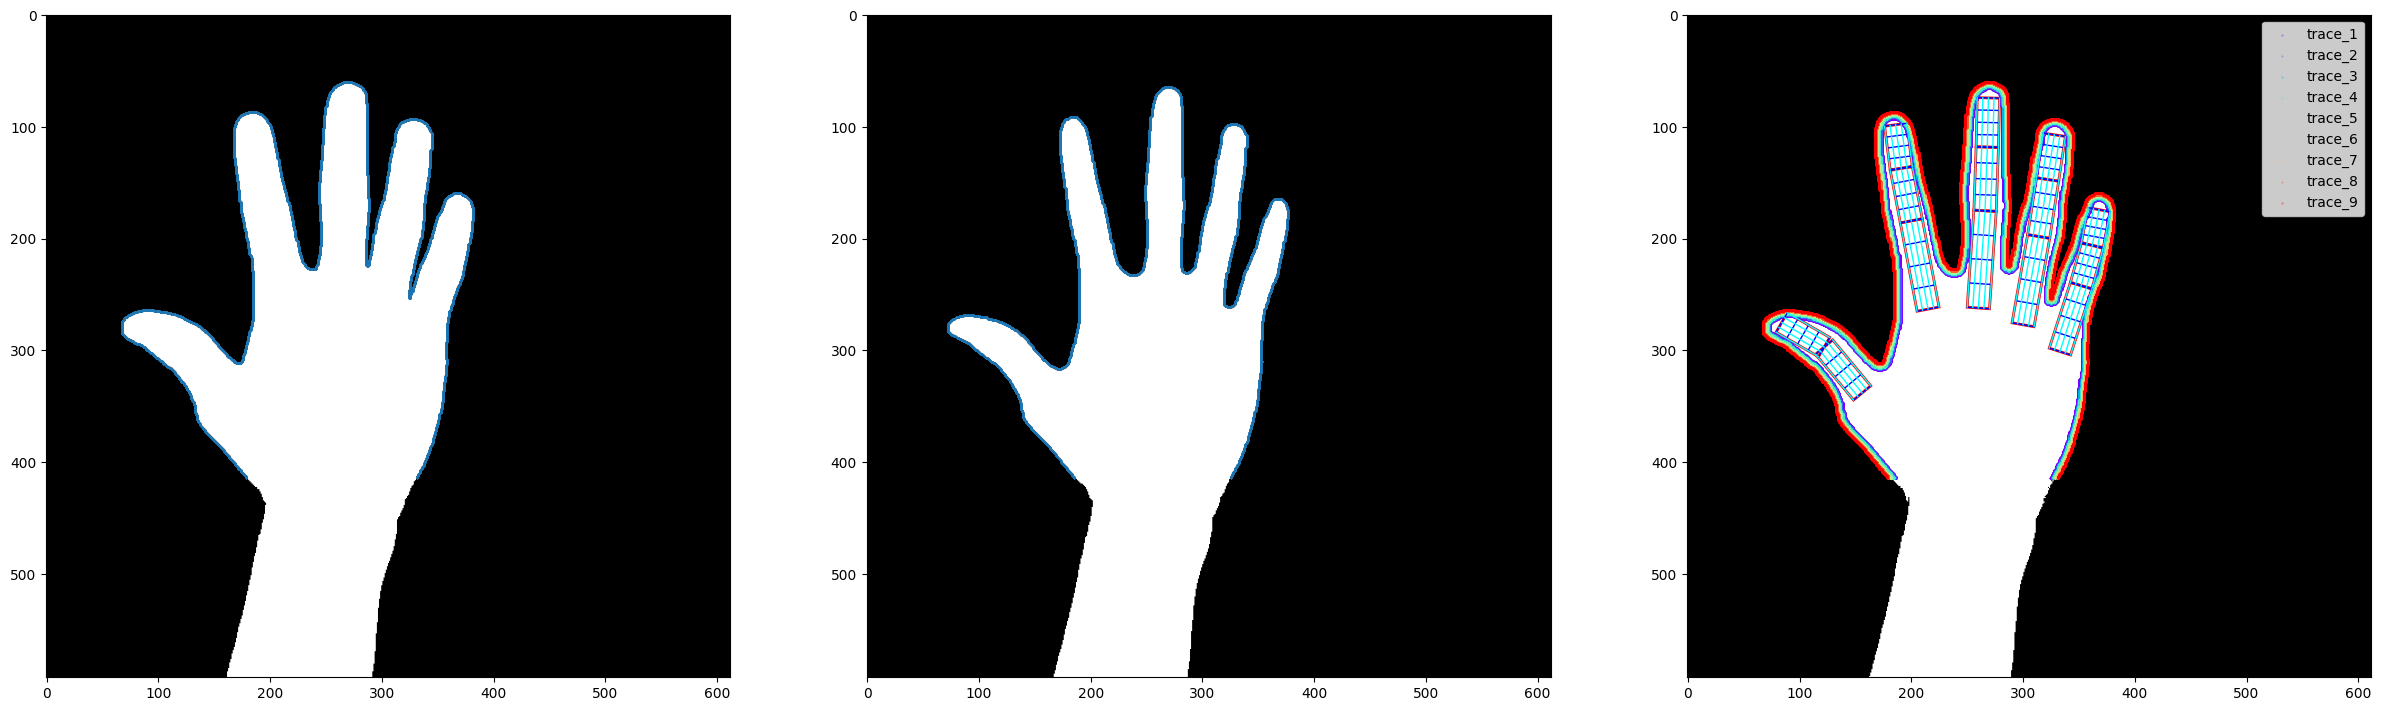

In [13]:
# source Link
inner_path, inner_segments = samplePaths('assets/solderMask.svg')
outer_path, outer_segments = samplePaths('assets/outerOnly.svg')
inner_path = inner_path / np.array(inner_path).max(0)
outer_path_n = outer_path / np.array(outer_path).max(0)

# Perform deformation
# bottom points for cutoff
hand_landmarks = result.multi_hand_landmarks[0]
x = (hand_landmarks.landmark[0].x)
y = (hand_landmarks.landmark[0].y)
binary_image = imageio.imread('mask.png')
boundary = int(y * mask.shape[0])


print('original', binary_image.sum())

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(30, 10))
print(binary_image.max())

smoothed_v2 = smooth_hand_mask(binary_image)

v2_outer = extrude_outward(smoothed_v2, 2)
outer_target, l_inner_target = contour_hand(v2_outer, boundary)
ax1.scatter(outer_target[:, 1], outer_target[:, 0], s=0.01)
ax1.imshow(v2_outer)

v2_inner = extrude_inward(smoothed_v2, 3)
inner_target, l_inner_target = contour_hand(v2_inner, boundary)
ax2.scatter(inner_target[:, 1], inner_target[:, 0], s=0.01)
ax2.imshow(v2_inner)


scalar_values = np.linspace(0, 1, 9)  # e.g., linearly spaced values from 0 to 1
# Create a colormap (e.g., 'viridis')
cmap = plt.cm.rainbow
colors = cmap(scalar_values)  # Map scalar values to colors

draw_finger_polygons_with_matplotlib(ax3, binary_image, finger_rectangles)

for i in range(9):
    v2_inner = extrude_inward(v2_outer, 0.7*(8-i))
    inner_target_l, l_inner_target = contour_hand(v2_inner, boundary)
    ax3.scatter(inner_target_l[:, 1], inner_target_l[:, 0], s=0.05, c=colors[i], label=f'trace_{i+1}')
    

ax3.legend()




/tmp/ipykernel_2930964/3836852406.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread('mask.png')


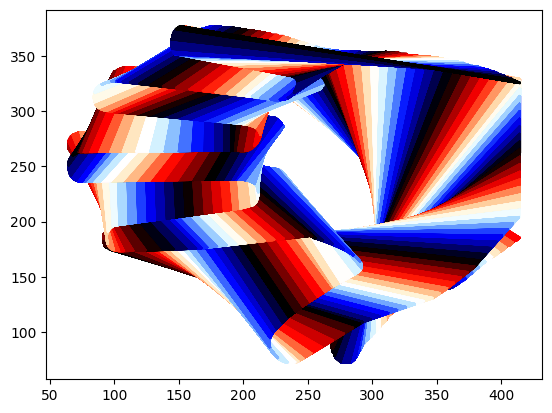

In [50]:
# map inner to inner, outer to outer

# rescale source to target:
s = (inner_target.max(0) - inner_target.min(0)) / (inner_path.max(0) - inner_path.min(0))
v_inner_target_n = s * ( inner_path - inner_path.min(0) ) + inner_target.min(0)

control_points_indices = np.linspace(0, v_inner_target_n.shape[0] - 1, num=10, dtype=int)

deformed_vertices = deform_shape(inner_path, inner_target, l_inner_target[:-1])

scalar_values = np.linspace(0, 1, v_inner_target_n.shape[0])  # e.g., linearly spaced values from 0 to 1
# Create a colormap (e.g., 'viridis')
cmap = plt.cm.flag
colors = cmap(scalar_values)  # Map scalar values to colors

# Define start and end points of the line segments
for i in range(v_inner_target_n.shape[0]):
    plt.plot((v_inner_target_n[i, 0], deformed_vertices[i, 0]), (v_inner_target_n[i, 1], deformed_vertices[i, 1]), color=colors[i])  # Plot as blue line
plt.show()


# plt.scatter(v_inner_target_n[:, 0], v_inner_target_n[:, 1], color='blue', s=5)
# plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
# plt.show()
